In [1]:
import numpy as np
# Importing Pandas Library 
import pandas as pd
import matplotlib.pyplot as plt
from preprocessing import *
import os
import joblib
from sklearn.preprocessing import MinMaxScaler
from utils import *

import tensorflow as tf
import keras
from tensorflow.keras.models import Model, load_model

from models.EEGNet import *

from sklearn.metrics import confusion_matrix

from preprocessing import *

2024-10-26 13:43:39.019435: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-26 13:43:39.026188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-26 13:43:39.033625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-26 13:43:39.035871: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-26 13:43:39.041670: I tensorflow/core/platform/cpu_feature_guar

In [2]:
@keras.saving.register_keras_serializable(package="my_package", name="UpdatedIoU")
class UpdatedIoU(tf.keras.metrics.IoU):
  def __init__(self,
        num_classes,
        target_class_ids,
        name=None,
        dtype=None,
        ignore_class=None,
        sparse_y_true=True,
        sparse_y_pred=True,
        axis=-1
    ):
    super(UpdatedIoU, self).__init__(
        num_classes=num_classes,
        target_class_ids=target_class_ids,
        name=name,
        dtype=dtype,
        ignore_class=ignore_class,
        sparse_y_true=sparse_y_true,
        sparse_y_pred=sparse_y_pred,
        axis=axis
    )

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
model = load_model(r'./checkpoints/orthogonal_standard_64_timesteps_trainable_True.keras')
model.summary()

I0000 00:00:1729925019.853795  206424 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729925019.875834  206424 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729925019.877160  206424 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729925019.879487  206424 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ eyebrows input      │ (None, 4, 64, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ left input          │ (None, 4, 64, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right input         │ (None, 4, 64, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ both input          │ (None, 4, 64, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teeth input         │ (None, 4, 64, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eyebrows            │ (None, 32)        │      2,848 │ eyebrows          │
│ (Functional)        │                   │            │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ left (Functional)   │ (None, 32)        │      2,848 │ left input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right (Functional)  │ (None, 32)        │      2,848 │ right input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ both (Functional)   │ (None, 32)        │      2,848 │ both input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teeth (Functional)  │ (None, 32)        │      2,848 │ teeth input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ eyebrows[0][0],   │
│ (Concatenate)       │                   │            │ left[0][0],       │
│                     │                   │            │ right[0][0],      │
│                     │                   │            │ both[0][0],       │
│                     │                   │            │ teeth[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │    164,864 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 384)       │    196,992 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 64, 6)     │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax             │ (None, 64, 6)     │          0 │ reshape[0][0]     │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,701,090 (10.30 MB)

 Trainable params: 900,096 (3.43 MB)

 Non-trainable params: 800 (3.12 KB)

 Optimizer params: 1,800,194 (6.87 MB)

In [5]:
from tensorflow.keras.utils import plot_model

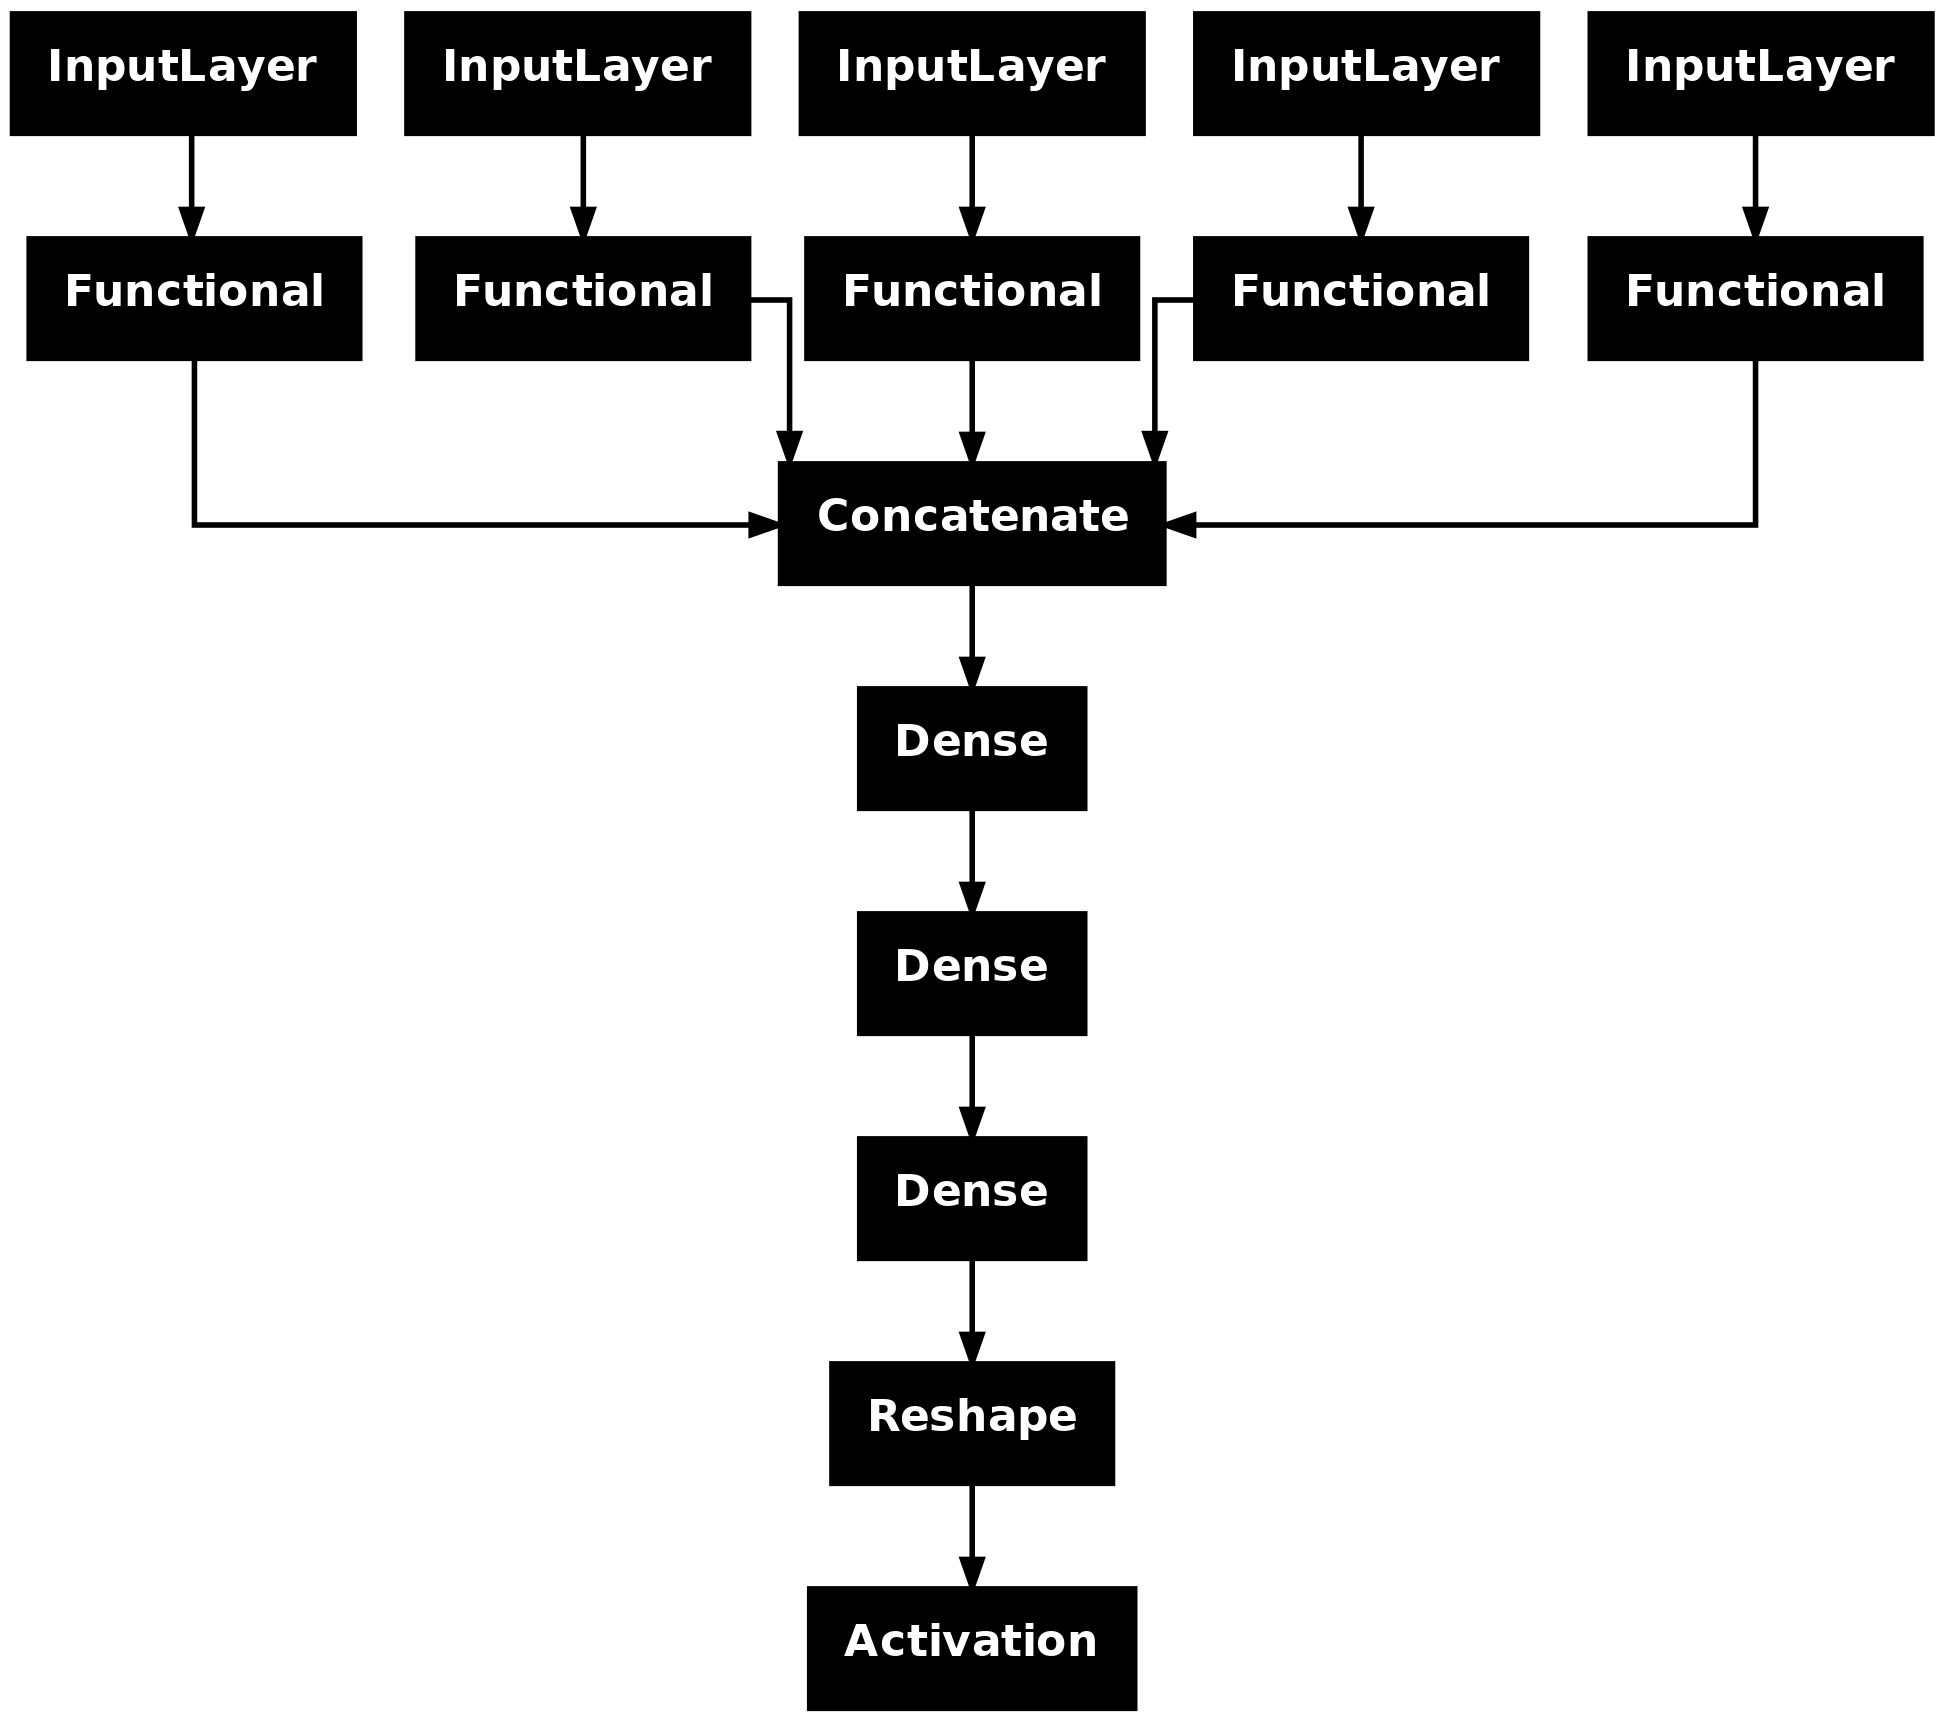

In [ ]:
plot_model(model)

In [7]:
df_eyebrows = pd.read_csv(r'./data/inference_data/eyebrows.csv').drop(columns=['timestamps', 'Right AUX'])
df_left = pd.read_csv(r'./data/inference_data/left.csv').drop(columns=['timestamps', 'Right AUX'])
df_right = pd.read_csv(r'./data/inference_data/right.csv').drop(columns=['timestamps', 'Right AUX'])
df_both = pd.read_csv(r'./data/inference_data/both.csv').drop(columns=['timestamps', 'Right AUX'])
df_teeth = pd.read_csv(r'./data/inference_data/teeth.csv').drop(columns=['timestamps', 'Right AUX'])

In [8]:
label_name = ['eyebrows', 'left', 'right', 'both', 'teeth']
scalers = {}
for label in label_name:
    scalers[label] = joblib.load(rf'./pipeline_{label}/checkpoints/scaler_standard.save')

In [9]:
filters = {
    'left': filter_left,
    'right': filter_right,
    'both': filter_both,
    'teeth': filter_teeth,
    'eyebrows': filter_eyebrows,
}

In [10]:
def get_input(df, time_step = 128):
    data = df.to_numpy()
    input_data = []
    
    for i in range(0, data.shape[0] // time_step * time_step, time_step):
        x_eyebrows = pipeline(data, filters['eyebrows'], scalers['eyebrows'], i, time_step)
        x_left = pipeline(data, filters['left'], scalers['left'], i, time_step)
        x_right = pipeline(data, filters['right'], scalers['right'], i, time_step)
        x_both = pipeline(data, filters['both'], scalers['both'], i, time_step)
        x_teeth = pipeline(data, filters['teeth'], scalers['teeth'], i, time_step)
        input_data.append(
            np.concatenate(
                [
                    x_eyebrows,
                    x_left,
                    x_right,
                    x_both,
                    x_teeth
                ],
                axis=1
            )
        )

    input_data = np.array(input_data)
    input_data = input_data[:, :, :, np.newaxis]
    input_data = input_data.transpose(0, 2, 1, 3)
    print(input_data.shape)
    
    return data, np.array(input_data)

In [11]:
def get_output(input_data):
    y_pred = model.predict([
        input_data[:, :4], 
        input_data[:, 4:8], 
        input_data[:, 8:12],
        input_data[:, 12:16],
        input_data[:, 16:20]
    ])
    y_pred = np.concatenate(y_pred, axis=0)
    y_pred_onehot = y_pred

    return y_pred_onehot

In [12]:
def plot_data_result(data, y_pred_onehot, title):
    plt.figure(figsize=(50, 30)).suptitle(title, fontsize=40)
    plt.subplot(9, 1, 1)
    plt.title("TP9", fontsize=40)
    plt.plot(data[:, 0])
    plt.subplot(9, 1, 2)
    plt.title("AF7", fontsize=40)
    plt.plot(data[:, 1])
    plt.subplot(9, 1, 3)
    plt.title("AF8", fontsize=40)
    plt.plot(data[:, 2])
    plt.subplot(9, 1, 4)
    plt.title("TP10", fontsize=40)
    plt.plot(data[:, 3])
    plt.subplot(9, 1, 5)
    plt.title("Result eyebrows", fontsize=40)
    plt.plot(y_pred_onehot[:, 1])
    plt.subplot(9, 1, 6)
    plt.title("Result left", fontsize=40)
    plt.plot(y_pred_onehot[:, 2])
    plt.subplot(9, 1, 7)
    plt.title("Result right", fontsize=40)
    plt.plot(y_pred_onehot[:, 3])
    plt.subplot(9, 1, 8)
    plt.title("Result both", fontsize=40)
    plt.plot(y_pred_onehot[:, 4])
    plt.subplot(9, 1, 9)
    plt.title("Result teeth", fontsize=40)
    plt.plot(y_pred_onehot[:, 5])

(140, 20, 64, 1)


I0000 00:00:1729925022.872911  206562 service.cc:146] XLA service 0x7daa200060e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729925022.872931  206562 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-10-26 13:43:42.881341: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-26 13:43:42.937189: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/5 ━━━━━━━━━━━━━━━━━━━━ 2s 569ms/step

I0000 00:00:1729925023.287969  206562 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


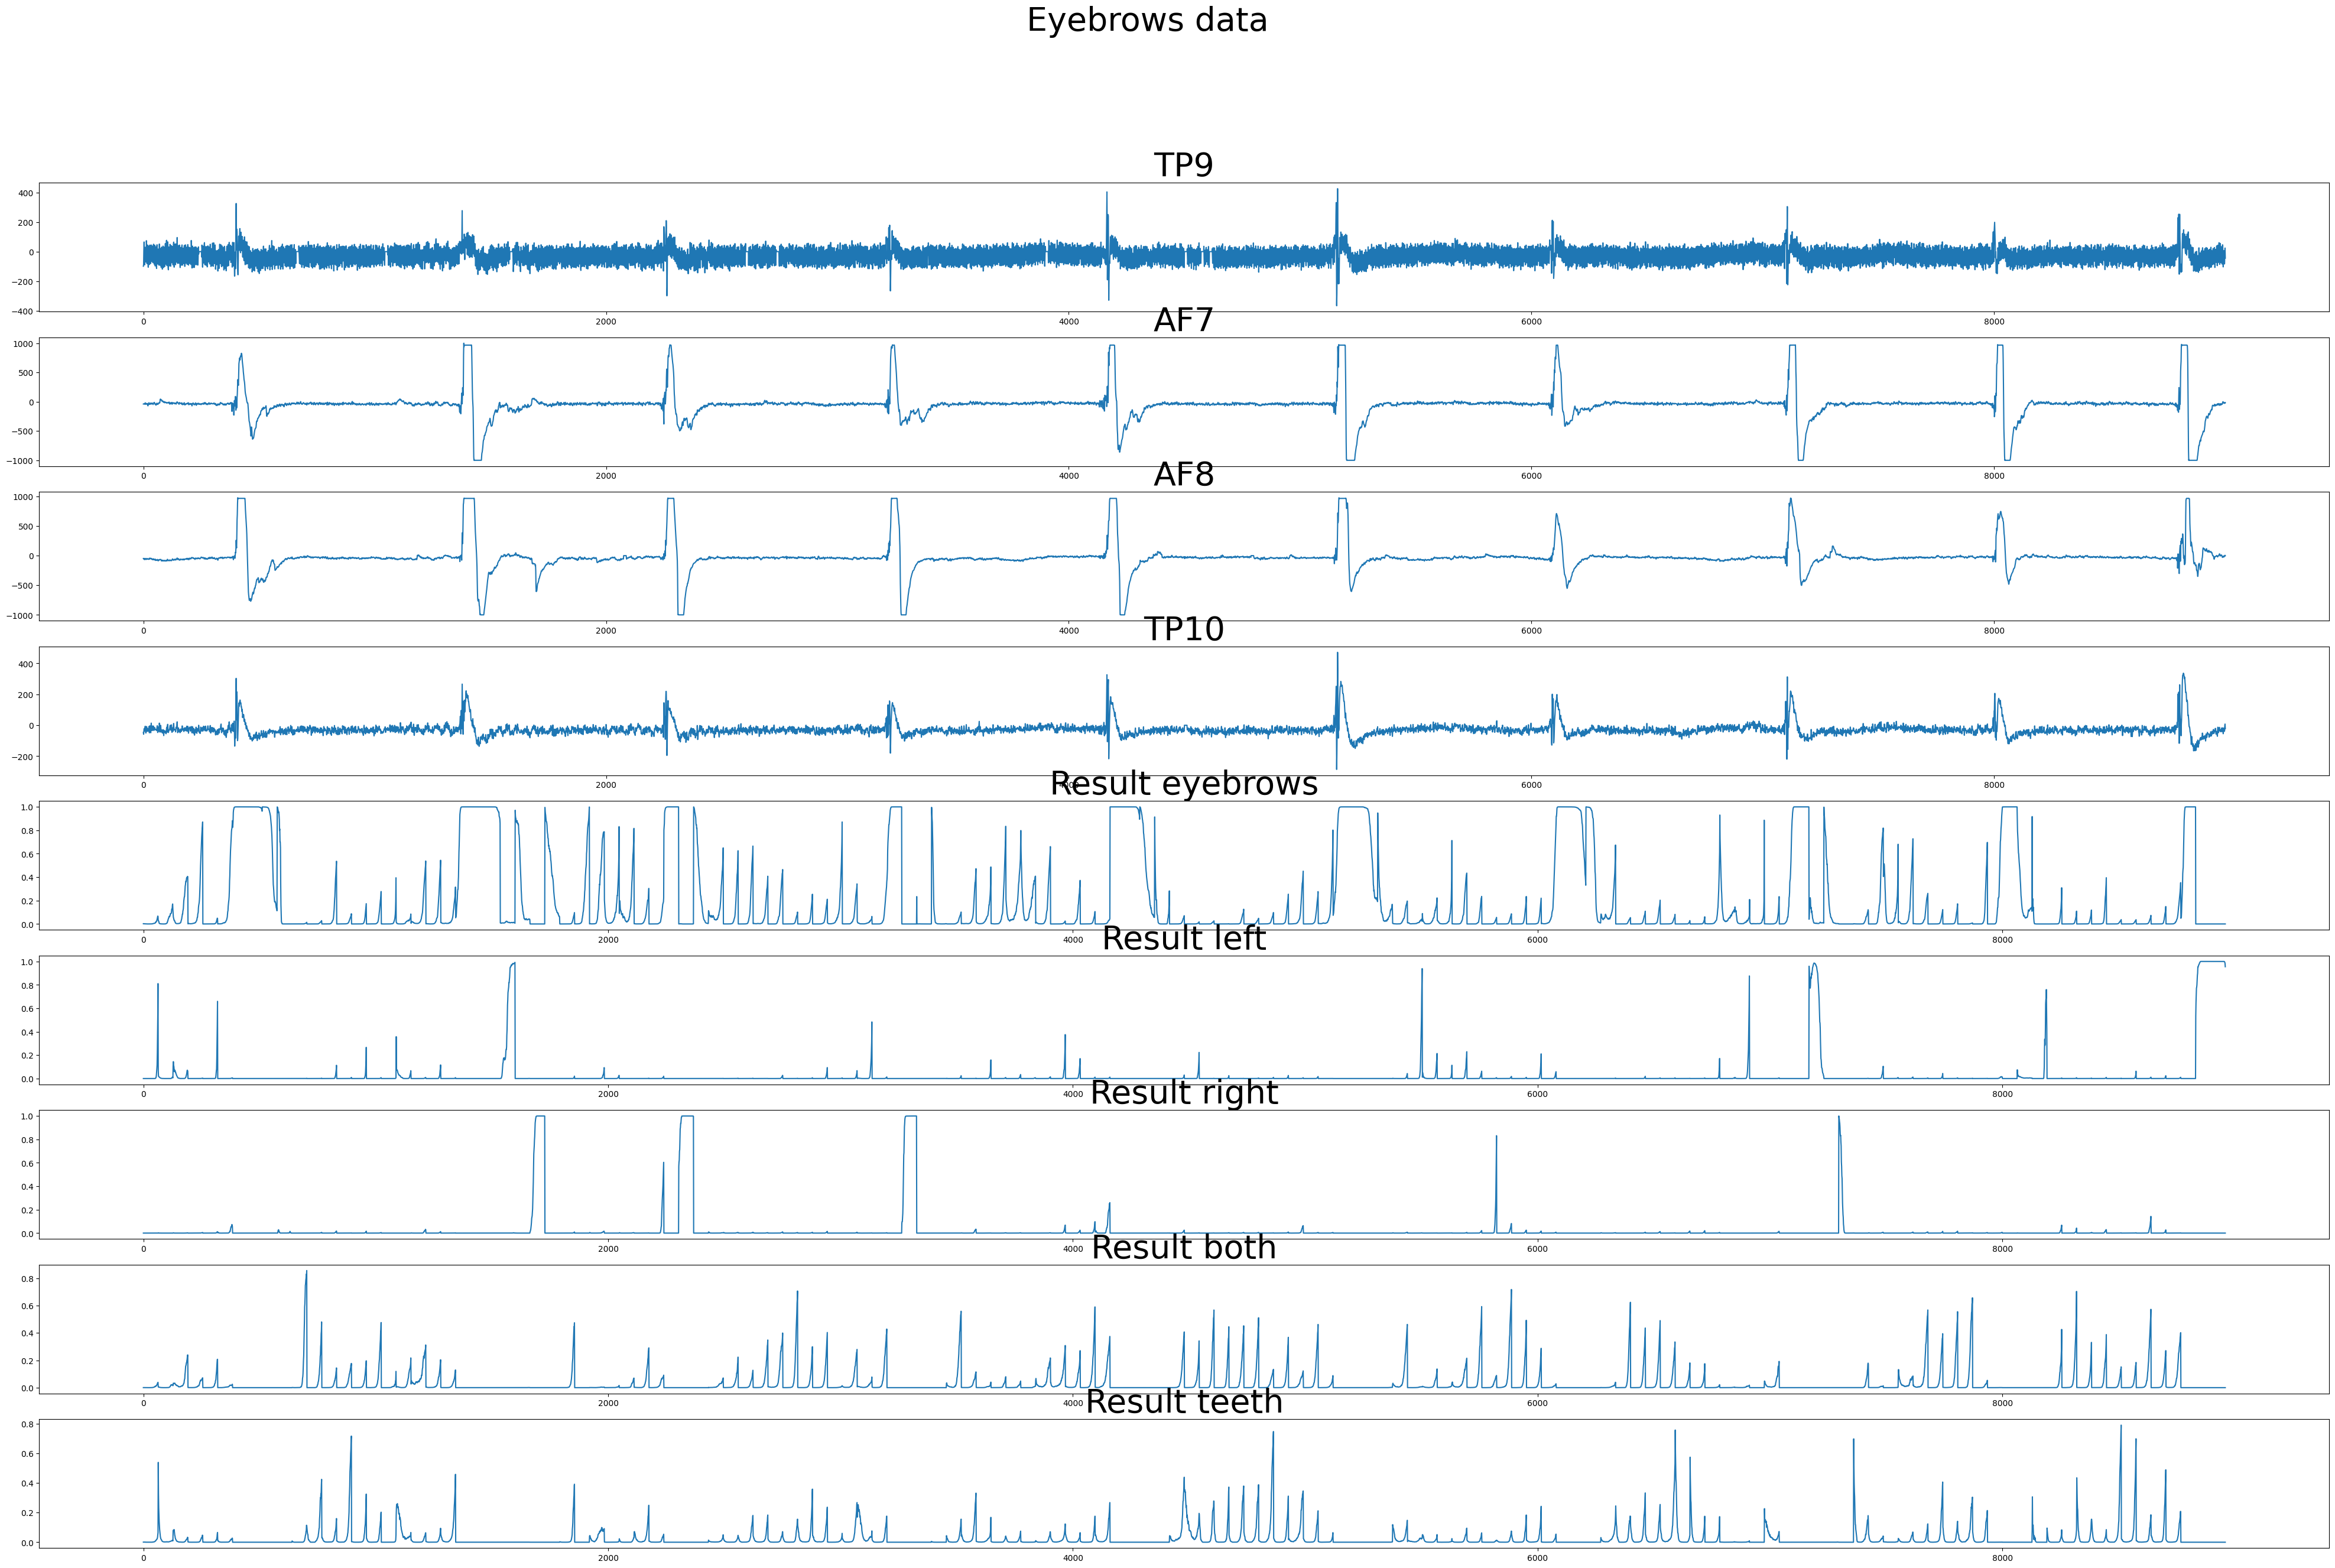

In [13]:
data, input_data = get_input(df_eyebrows, time_step=64)
y_pred_onehot = get_output(input_data)
plot_data_result(data, y_pred_onehot, "Eyebrows data")

(140, 20, 64, 1)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


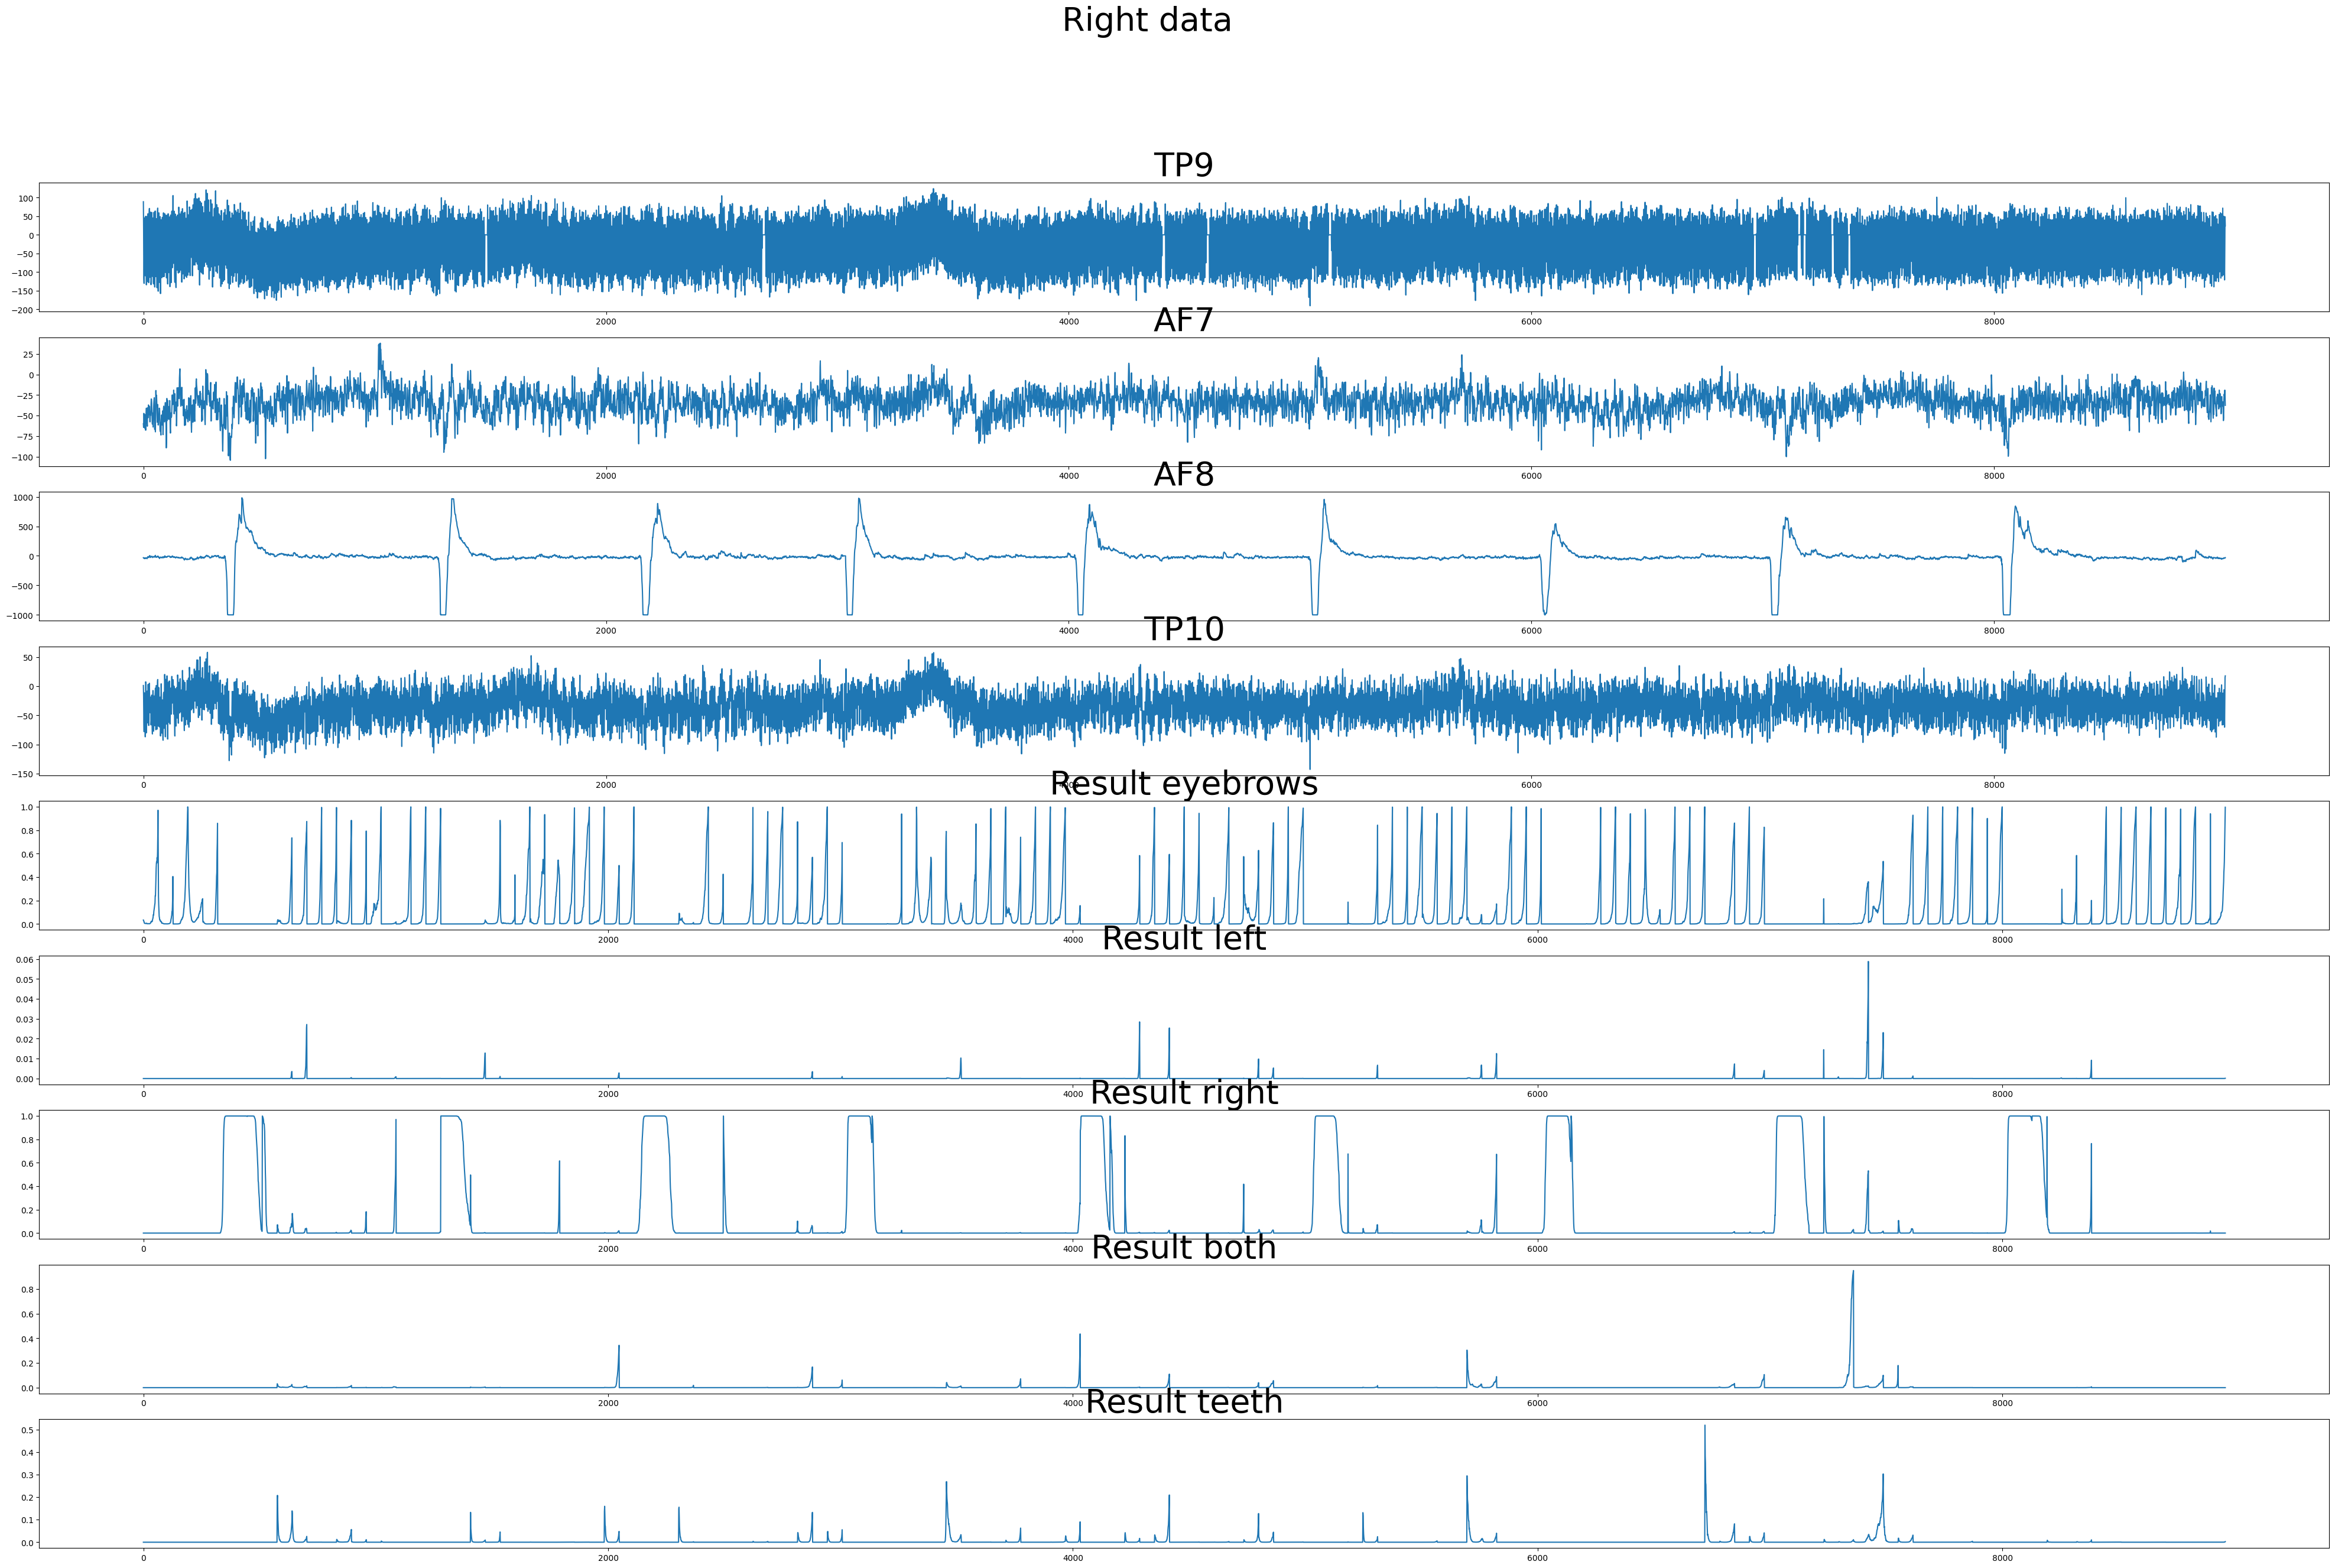

In [14]:
# Eyebrows inference dataset
data, input_data = get_input(df_right, time_step=64)
y_pred_onehot = get_output(input_data)
plot_data_result(data, y_pred_onehot, "Right data")

In [15]:
# Eyebrows inference dataset
data, input_data = get_input(df_left, time_step=64)
y_pred_onehot = get_output(input_data)
plot_data_result(data, y_pred_onehot, "Left data")

(140, 20, 64, 1)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


(160, 20, 64, 1)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


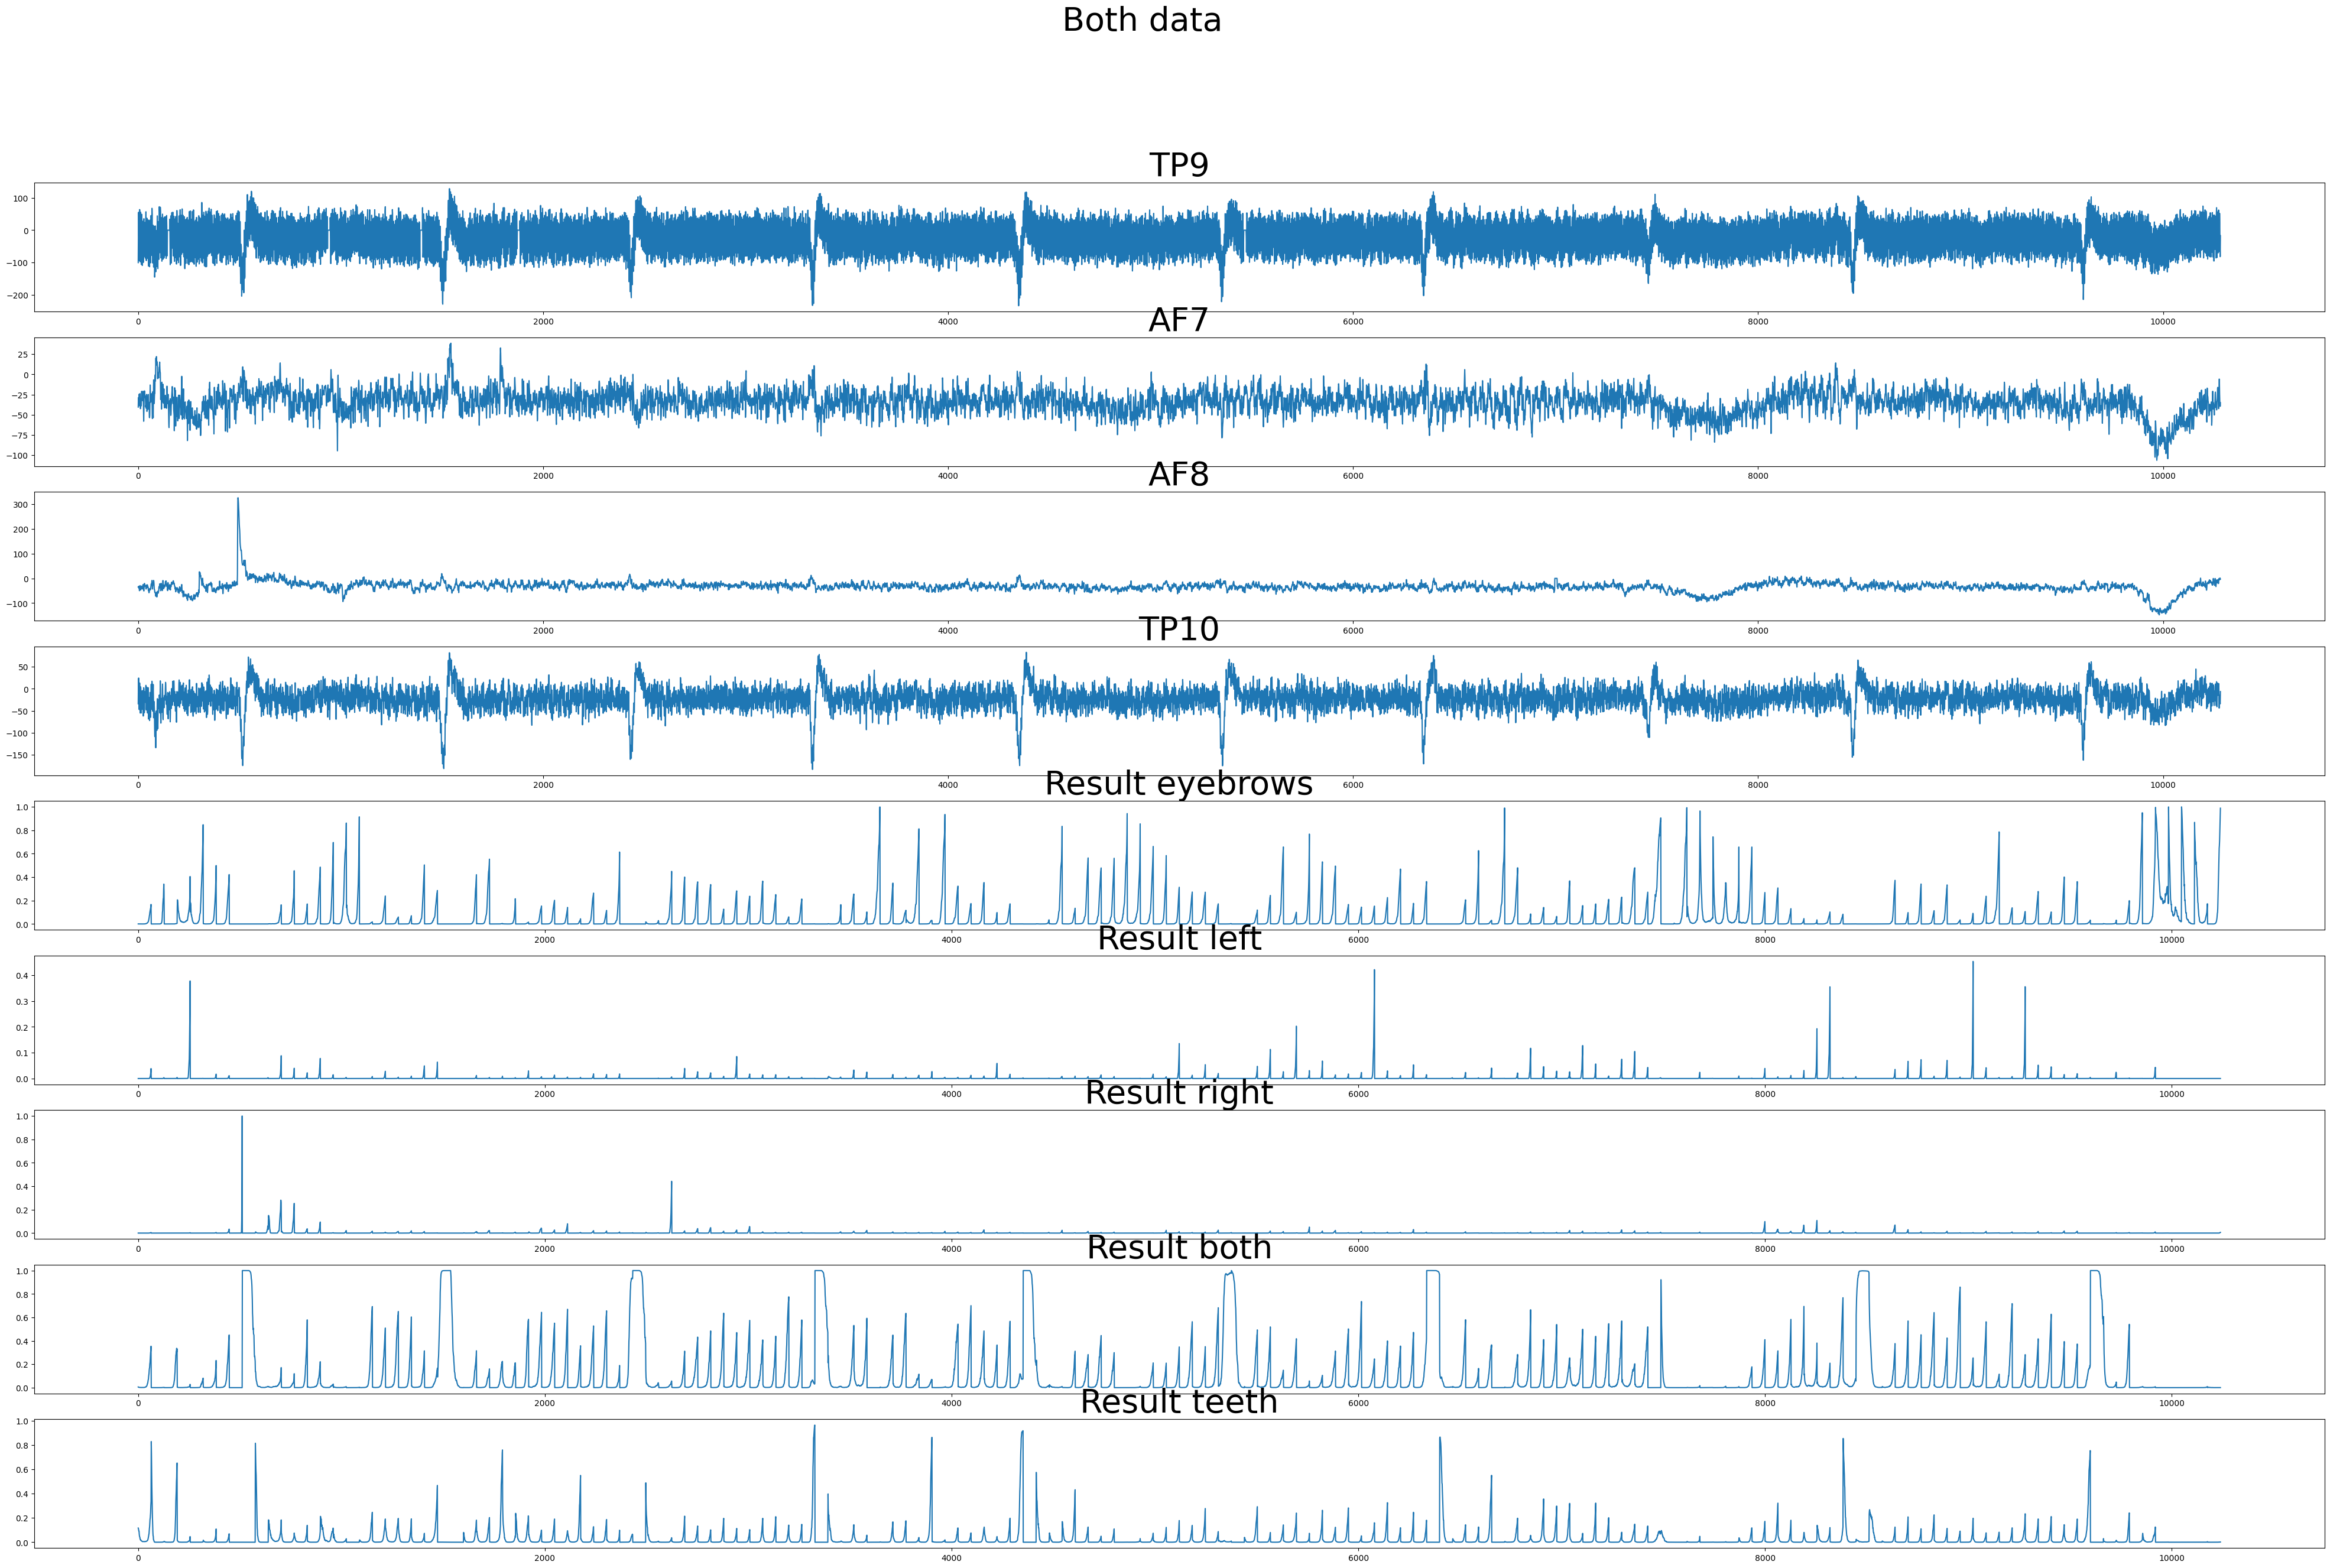

In [16]:
# Eyebrows inference dataset
data, input_data = get_input(df_both, time_step=64)
y_pred_onehot = get_output(input_data)
plot_data_result(data, y_pred_onehot, "Both data")

(120, 20, 64, 1)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


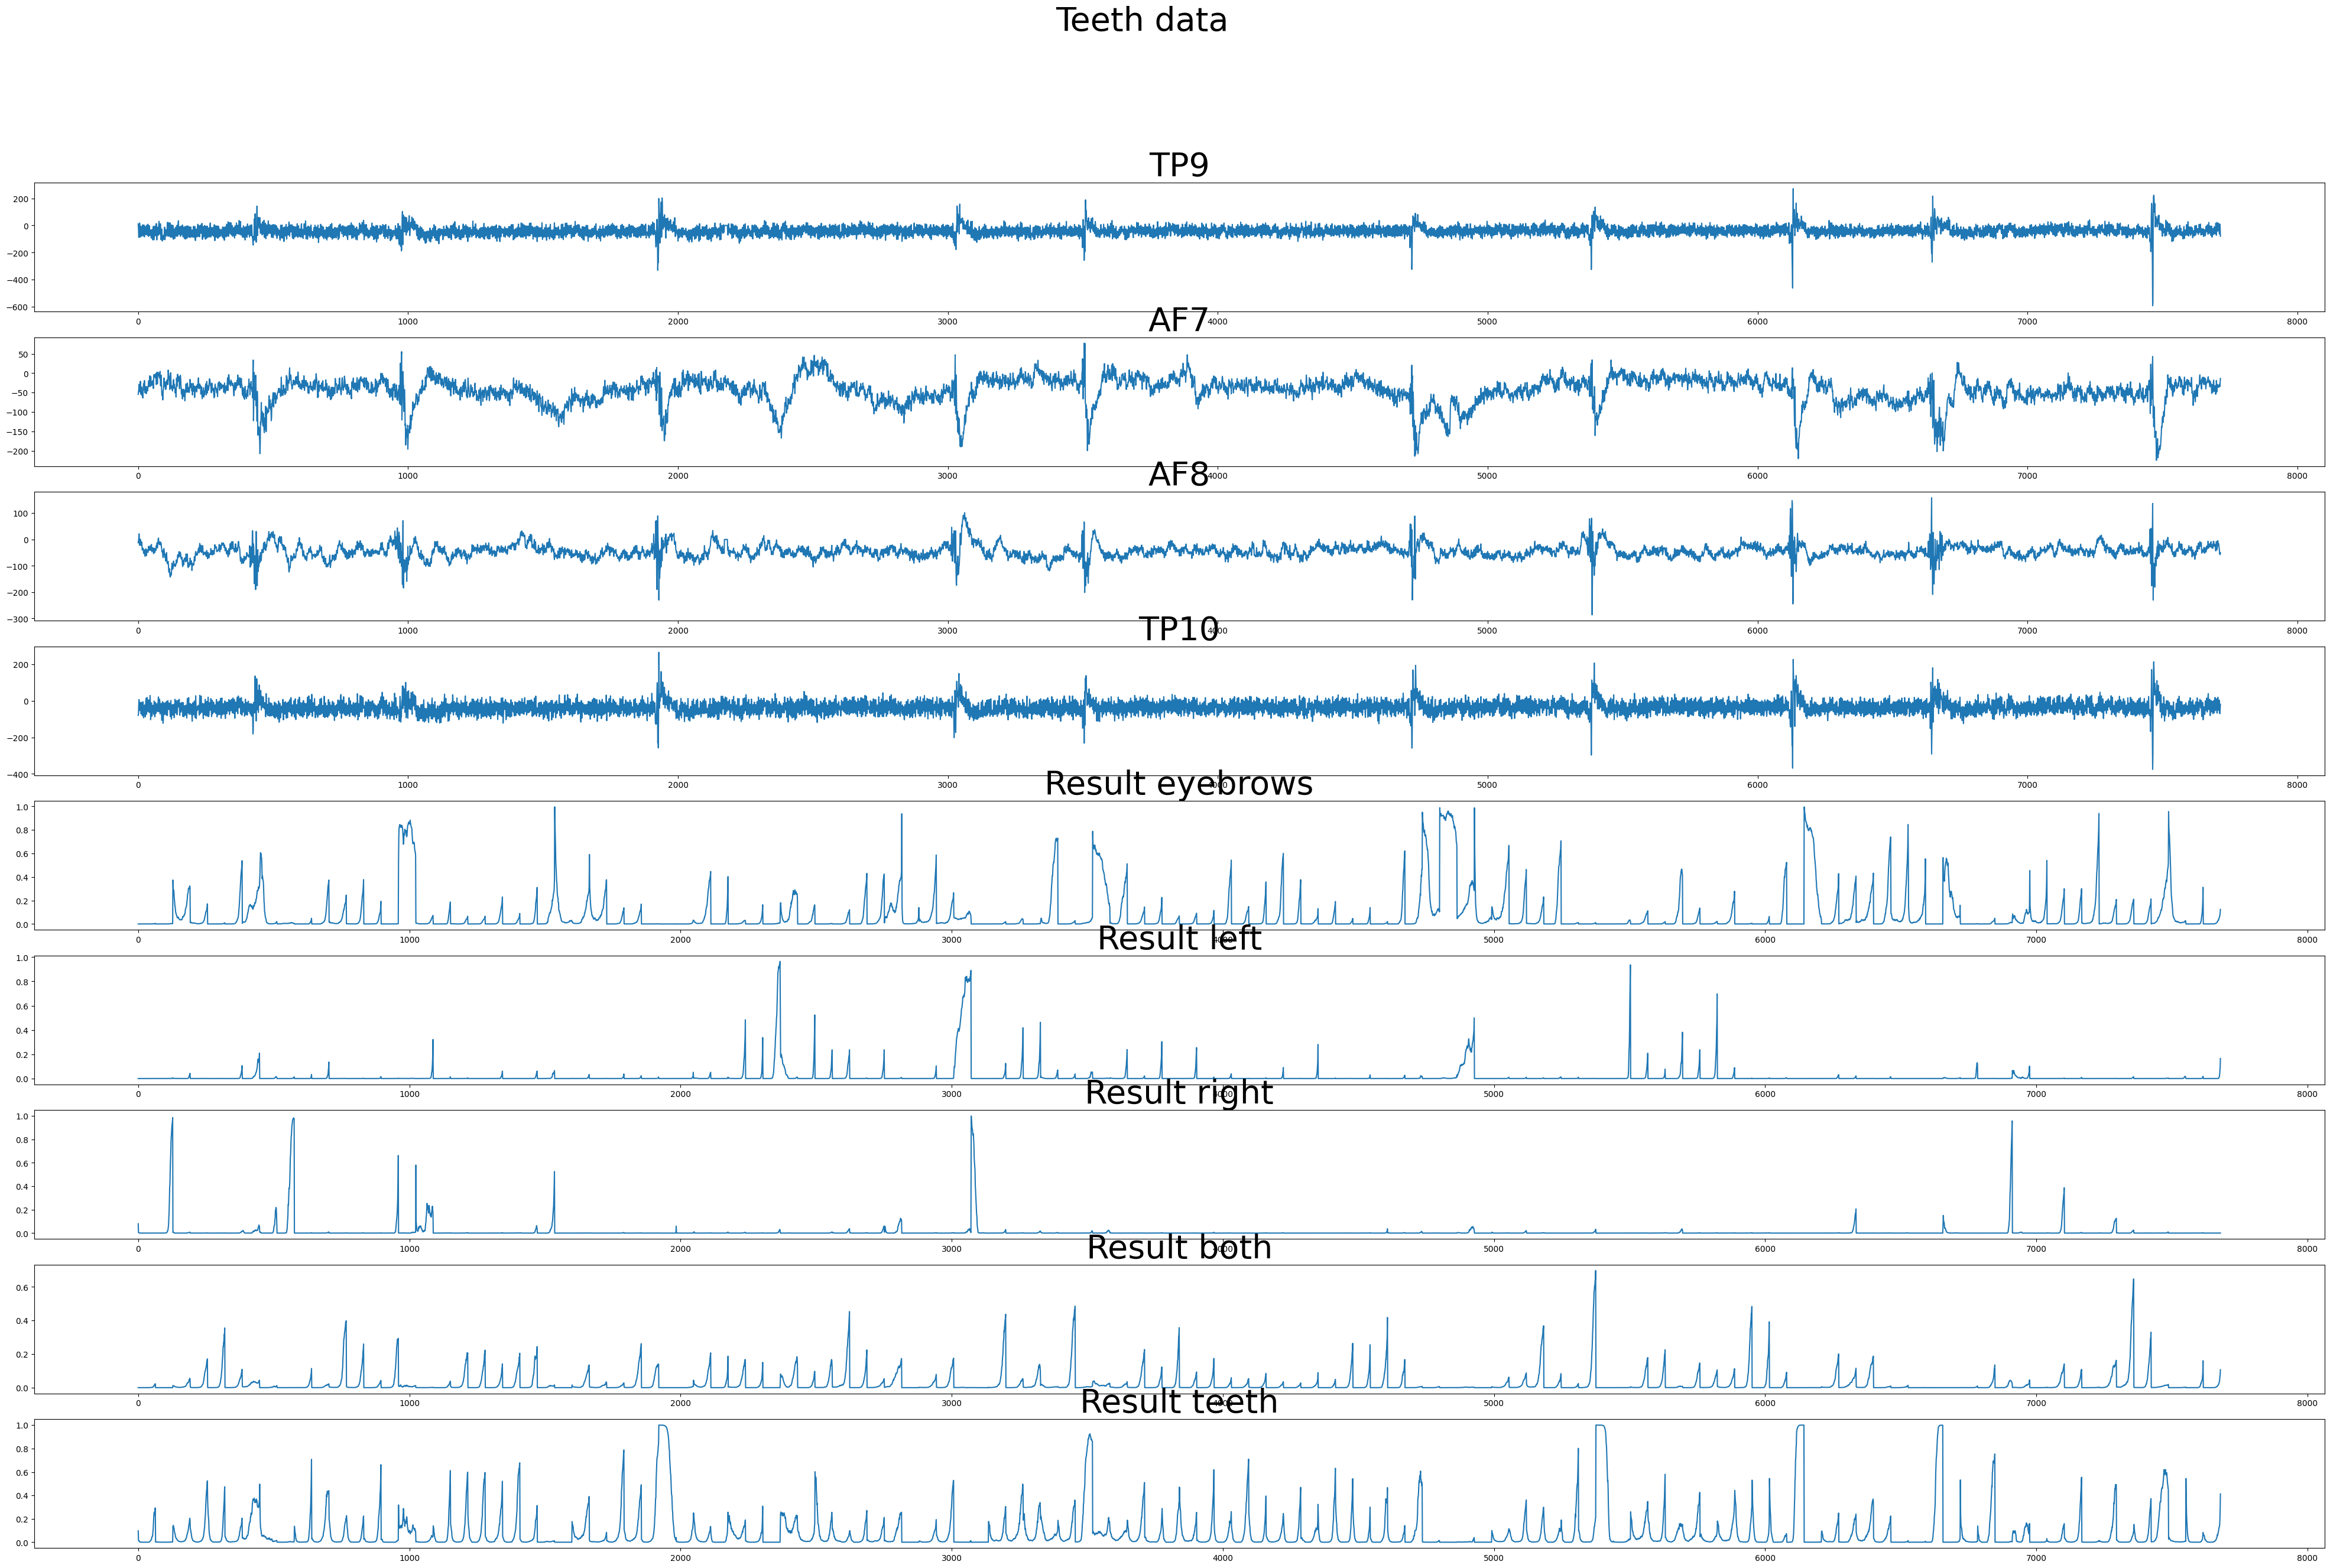

In [17]:
# Eyebrows inference dataset
data, input_data = get_input(df_teeth, time_step=64)
y_pred_onehot = get_output(input_data)
plot_data_result(data, y_pred_onehot, "Teeth data")